# Twitter US Airline Sentiment
Датасет брался отсюда (https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import re
import copy
from os import path, getcwd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
DATA_PATH = '/content/drive/MyDrive/HSE/NLP/my_project/Tweets.csv'
df = pd.read_csv(DATA_PATH)
data = df[{'text', 'airline_sentiment'}]
data

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


## Preprocessing

In [5]:
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

Уберем знаки препинания, теги авиакомпаний в твитах, а так же сделаем стемминг, который уберет и стоп-слова

In [6]:
def preprocess(df):
    d = {'negative': 0, 'neutral': 1, 'positive' : 2}
    tokenizer = RegexpTokenizer(r'\w+')    # оставляет только слова, без знаков препинания
    stemmer = SnowballStemmer('english', ignore_stopwords=False)
    tags = r'@\w*'
    for _, row in df.iterrows():
        row['airline_sentiment'] = d[row['airline_sentiment']]
        s = re.sub(tags, '', row['text'])    # убираем тэги компаний
        s = re.sub(r'[0-9]+', '', s)    # убираем числа
        s  = ' '.join([stemmer.stem(w) for w in tokenizer.tokenize(s.lower())])


        row['text'] = s

In [7]:
preprocess(data)
data

,text,airline_sentiment
0,what said,1
1,plus you ve ad commerci to the experi tacki,2
2,i didn t today must mean i need to take anoth ...,1
3,it s realli aggress to blast obnoxi entertain ...,0
4,and it s a realli big bad thing about it,0
...,...,...
14635,thank you we got on a differ flight to chicago,2
14636,leav over minut late flight no warn or communi...,0
14637,pleas bring american airlin to blackberri,1
14638,you have my money you chang my flight and don ...,0


Можно посмотреть, как все изменилось

In [8]:
for i in range(3, 8):
    print(f"original: {df['text'][i]}")
    print(f"procesed: {data['text'][i]}", '\n')

original: @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
procesed: it s realli aggress to blast obnoxi entertain in your guest face amp they have littl recours 

original: @VirginAmerica and it's a really big bad thing about it
procesed: and it s a realli big bad thing about it 

original: @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
procesed: serious would pay a flight for seat that didn t have this play it s realli the onli bad thing about fli va 

original: @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
procesed: yes near everi time i fli vx this ear worm won t go away 

original: @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP
procesed: realli miss a prime opportun for men without hat parodi there https t co mwpggrezp 



Векторизуем твиты с помощью TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
VOCAB_SIZE = 1024
vectorizer = TfidfVectorizer(encoding='ascii', max_features=VOCAB_SIZE)
X = vectorizer.fit_transform(data['text'])
y = data['airline_sentiment'].to_numpy().astype('int')

## Классический алгоритм

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier

Научимся считать метрики, для этого воспользуемся стандартными методами

In [12]:
def count_metrics(y_pred, y, average='macro'):
    acc = accuracy_score(y_pred, y)
    prec = precision_score(y_pred, y, average=average)
    rec = recall_score(y_pred, y,  average=average)
    # print(f'acc: {acc:.3f} prec: {prec:.3f} rec: {rec:.3f}')
    return acc, prec, rec

Метод k-ближайших соседей

In [13]:
neigh = 8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=neigh, weights="distance", n_jobs=-1)
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)

acc, prec, rec = count_metrics(y_test_pred, y_test, average='macro')
print(f'acc: {acc:.3f} prec: {prec:.3f} rec: {rec:.3f}')

acc: 0.343 prec: 0.429 rec: 0.544


Метод опорных векторов

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = OneVsRestClassifier(LinearSVC())
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
acc_svm, prec_svm, rec_svm = count_metrics(y_test_pred, y_test, average='macro')
print(f'acc: {acc_svm:.3f} prec: {prec_svm:.3f} rec: {rec_svm:.3f}')

acc: 0.797 prec: 0.708 rec: 0.747


Видно, что SVM значительно лучше работает, чем k-ближайший соседей

In [16]:
ind_example = np.random.choice(X_test.shape[0], 5)
X_expample, y_example = X_test[ind_example], y_test[ind_example]
y_pred = clf.predict(X_expample)
print(y_pred)
print(y_example)

[0 0 0 0 1]
[0 0 0 0 1]


## Нейросетевая модель

В нашем датасете 3 класса, поэтому научимся решать задачу мультиклассовой классификации по редсказанию сентимента твита.

Закодируем лейблы в one-hot векторы

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
y_ = OneHotEncoder().fit_transform(y.reshape(-1,1)).toarray()
print(y_)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


Построим модель, это будет трехслойная полносвязная нейронная сеть, параметры модели напишем позже

In [19]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [20]:
class Model(nn.Module):
    def __init__(self, in_size, out_size, shape=(1024, 512)):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.shape = shape
        self.layes = nn.Sequential(
            nn.Linear(in_size, shape[0]),
            nn.ReLU(),
            nn.Linear(*self.shape),
            nn.ReLU(),
            nn.Linear(shape[1], out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layes(x)
        return out


In [21]:
from scipy import sparse


Чтобы воспользоваться DataLoader-ом, определим дочерний класс от Dataset

In [22]:
class dataset(Dataset):
    def __init__(self, X, y):
        assert X.shape[0] == y.shape[0]
        if isinstance(X, sparse.spmatrix):
            X = X.toarray()
        if isinstance(y, sparse.spmatrix):
            y = y.toarray()
        self.X = copy.deepcopy(X)
        self.y = copy.deepcopy(y)
        self.num_samples = self.X.shape[0]
        self.inds = np.arange(self.num_samples)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return self.X[index], self.y[index]

Научимся делать один проход нейронной сети, сразу же будем считать средние значения метрик на батчах

In [40]:
def single_pass(model, dataset, loss_function, device, optimizator):
    loss_mean, acc_mean, prec_mean, rec_mean, batch_sizes  = [], [], [], [], []
    for X, y in dataset:
        # X = torch.tensor(X.data, dtype=torch.float32, device=device)
        # y = torch.tensor(y.data, dtype=torch.float32, device=device)
        X = X.type(torch.float32)
        y = y.type(torch.float32)
        out = model.forward(X)
        loss = loss_function(out, y)
        loss_mean.append(loss.item())
        y_pred = np.round(out.cpu().detach().numpy()).astype('uint8')   ### cpu()
        acc, prec, rec = count_metrics(y_pred, y)
        acc_mean.append(acc)
        prec_mean.append(prec)
        rec_mean.append(rec)
        batch_sizes.append(X.shape[0])

        if optimizator is not None:
            optimizator.zero_grad()
            loss.backward()
            optimizator.step()
    # count mean metrics
    batch_sizes = np.array(batch_sizes)
    num_samples = np.sum(batch_sizes)

    loss_mean = np.array(loss_mean)
    acc_mean = np.array(acc_mean)
    prec_mean = np.array(prec_mean)
    rec_mean = np.array(rec_mean)

    loss_mean = np.sum(loss_mean * batch_sizes) / num_samples
    acc_mean = np.sum(acc_mean * batch_sizes) / num_samples
    prec_mean = np.sum(prec_mean * batch_sizes) / num_samples
    rec_mean = np.sum(rec_mean * batch_sizes) / num_samples

    return loss_mean, acc_mean, prec_mean, rec_mean

Научимся обучать нашу модель и собирать метрики

In [41]:
def train(model, train_dataset, val_dataset, device, epochs=20, lr=1e-3):
    optimizator = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.BCELoss()

    train_losses = np.zeros(epochs)
    train_metrics = np.zeros((epochs, 3))
    val_losses = np.zeros_like(train_losses)
    val_metrics = np.zeros_like(train_metrics)

    for i in range(epochs):
        print(f'Epoch {i + 1}')
        loss, acc, prec, rec = single_pass(model, train_dataset, loss_function, device, optimizator)
        # train_dataset.shuffle()

        print(f'Train: loss = {loss:.3f},', end=' ')
        print(f'acc = {acc:.3f}, prec = {prec:.3f}, rec = {rec:.3f}')
        train_losses[i] = loss
        train_metrics[i, :] = acc, prec, rec

        with torch.no_grad():
            loss, acc, prec, rec = single_pass(model, val_dataset, loss_function, device, optimizator=None)

        print(f'Validation: loss = {loss:.3f},', end=' ')
        print(f'acc = {acc:.3f}, prec = {prec:.3f}, rec = {rec:.3f}')
        print()
        val_losses[i] = loss
        val_metrics[i, :] = acc, prec, rec

    return train_losses, val_losses, train_metrics, val_metrics


И строить графики

In [42]:
def plot_results(ax, train_results, val_results, test_result, label):
    epochs = np.arange(1, len(train_results) + 1)
    ax.plot(epochs, train_results, label='train')
    ax.plot(epochs, val_results, label='validation')
    if test_result is not None:
        ax.plot(epochs[-1], test_result,
                marker='o', linestyle='none', label='test')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(label)
    ax.grid(linestyle=':')
    ax.legend()

Определим параметры модели

In [43]:
BATCH_SIZE = 1024
LEARNING_RATE = 1e-3
HIDDEN_IN = 1024
HIDDEN_OUT = 512
EPOCHS = 25

Разделим датасет на train/test/validation

In [44]:
from torch.utils.data import DataLoader

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

train_dataset = DataLoader(dataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE)
val_dataset = DataLoader(dataset(X_val, y_val), shuffle=True, batch_size=BATCH_SIZE)
test_dataset = DataLoader(dataset(X_test, y_test), shuffle=True, batch_size=BATCH_SIZE)

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(X.shape[1], y_.shape[1], (HIDDEN_IN, HIDDEN_OUT))
model = model.to(device)

Обучим модель\
Я не справился с тем, чтобы найти, где возникает UserWarnigs, поэтому там очень сложно читать то, что выводится

In [47]:
train_losses, val_losses, train_metrics, val_metrics = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device=device,
    epochs=EPOCHS,
    lr=LEARNING_RATE
)

Epoch 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Train: loss = 0.605, acc = 0.574, prec = 0.362, rec = 0.214
Validation: loss = 0.508, acc = 0.635, prec = 0.333, rec = 0.212

Epoch 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Train: loss = 0.489, acc = 0.628, prec = 0.333, rec = 0.209
Validation: loss = 0.454, acc = 0.635, prec = 0.333, rec = 0.212

Epoch 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Train: loss = 0.430, acc = 0.628, prec = 0.333, rec = 0.211
Validation: loss = 0.405, acc = 0.635, prec = 0.333, rec = 0.227

Epoch 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Train: loss = 0.381, acc = 0.616, prec = 0.328, rec = 0.324
Validation: loss = 0.370, acc = 0.612, prec = 0.331, rec = 0.602

Epoch 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: loss = 0.337, acc = 0.648, prec = 0.426, rec = 0.826
Validation: loss = 0.336, acc = 0.682, prec = 0.537, rec = 0.837

Epoch 6
Train: loss = 0.284, acc = 0.766, prec = 0.668, rec = 0.862
Validation: loss = 0.315, acc = 0.727, prec = 0.658, rec = 0.765

Epoch 7
Train: loss = 0.249, acc = 0.804, prec = 0.760, rec = 0.839
Validation: loss = 0.317, acc = 0.748, prec = 0.698, rec = 0.758

Epoch 8
Train: loss = 0.228, acc = 0.827, prec = 0.786, rec = 0.850
Validation: loss = 0.322, acc = 0.754, prec = 0.691, rec = 0.754

Epoch 9
Train: loss = 0.210, acc = 0.840, prec = 0.800, rec = 0.866
Validation: loss = 0.327, acc = 0.754, prec = 0.690, rec = 0.750

Epoch 10
Train: loss = 0.193, acc = 0.859, prec = 0.822, rec = 0.881
Validation: loss = 0.334, acc = 0.751, prec = 0.686, rec = 0.749

Epoch 11
Train: loss = 0.175, acc = 0.875, prec = 0.841, rec = 0.893
Validation: loss = 0.343, acc = 0.751, prec = 0.694, rec = 0.741

Epoch 12
Train: loss = 0.155, acc = 0.891, prec = 0.861, rec = 0.907

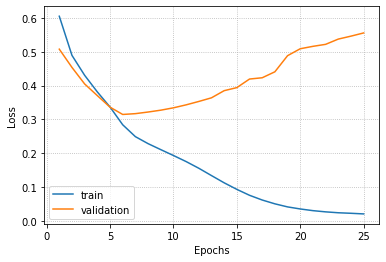

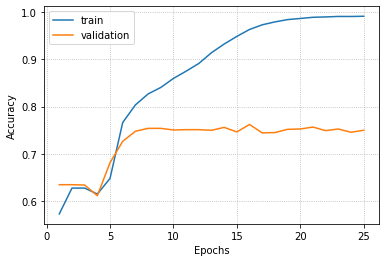

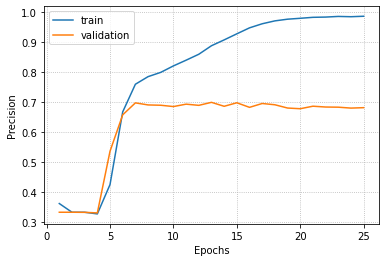

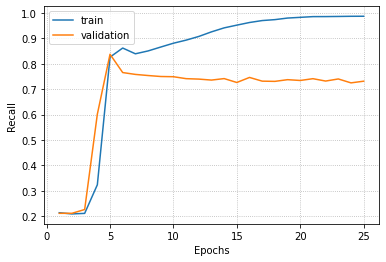

In [48]:
# plot results
_, ax1 = plt.subplots()
ax1 = plot_results(ax1, train_losses, val_losses, None, 'Loss')
_, ax2 = plt.subplots()
ax2 = plot_results(ax2, train_metrics[:, 0], val_metrics[:, 0],
                   None, 'Accuracy')
_, ax3 = plt.subplots()
ax3 = plot_results(ax3, train_metrics[:, 1], val_metrics[:, 1],
                   None, 'Precision')
_, ax4 = plt.subplots()
ax4 = plot_results(ax4, train_metrics[:, 2], val_metrics[:, 2],
                   None, 'Recall')
plt.show()

Видно, что на 8 эпохе можно остановиться, поэтому обучим сеть на 8 эпохе и сравним результаты на тесте с результатами SVM

In [49]:
EPOCHS = 8

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

train_dataset = DataLoader(dataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE)
val_dataset = DataLoader(dataset(X_val, y_val), shuffle=True, batch_size=BATCH_SIZE)
test_dataset = DataLoader(dataset(X_test, y_test), shuffle=True, batch_size=BATCH_SIZE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(X.shape[1], y_.shape[1], (HIDDEN_IN, HIDDEN_OUT))
model = model.to(device)

train_losses, val_losses, train_metrics, val_metrics = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device=device,
    epochs=EPOCHS,
    lr=LEARNING_RATE
)


Epoch 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Train: loss = 0.603, acc = 0.582, prec = 0.311, rec = 0.216
Validation: loss = 0.524, acc = 0.620, prec = 0.333, rec = 0.207

Epoch 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Train: loss = 0.493, acc = 0.626, prec = 0.333, rec = 0.209
Validation: loss = 0.465, acc = 0.620, prec = 0.333, rec = 0.207

Epoch 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Train: loss = 0.434, acc = 0.626, prec = 0.333, rec = 0.211
Validation: loss = 0.422, acc = 0.617, prec = 0.332, rec = 0.223

Epoch 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Train: loss = 0.386, acc = 0.611, prec = 0.326, rec = 0.253
Validation: loss = 0.388, acc = 0.585, prec = 0.315, rec = 0.263

Epoch 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Train: loss = 0.344, acc = 0.602, prec = 0.341, rec = 0.582
Validation: loss = 0.356, acc = 0.638, prec = 0.472, rec = 0.864

Epoch 6
Train: loss = 0.296, acc = 0.726, prec = 0.597, rec = 0.881
Validation: loss = 0.329, acc = 0.708, prec = 0.638, rec = 0.782

Epoch 7
Train: loss = 0.255, acc = 0.791, prec = 0.734, rec = 0.844
Validation: loss = 0.333, acc = 0.738, prec = 0.695, rec = 0.759

Epoch 8
Train: loss = 0.232, acc = 0.818, prec = 0.777, rec = 0.843
Validation: loss = 0.338, acc = 0.742, prec = 0.692, rec = 0.754



Посмотрим на метрики на тесте

In [51]:
# evaluate model on test dataset
test_loss, test_acc, test_prec, test_rec = single_pass(
    model, test_dataset, nn.BCELoss(), device, None
)
print(f'acc: {test_acc:.3f} prec: {test_prec:.3f} rec: {test_rec:.3f}')

acc: 0.757 prec: 0.692 rec: 0.760


У SVM были такие метрики

In [52]:
print(f'acc: {acc_svm:.3f} prec: {prec_svm:.3f} rec: {rec_svm:.3f}')

acc: 0.797 prec: 0.708 rec: 0.747


Видно, что у нейронной сети precision и accuracy даже чуть меньше, чем у SVM. Получается, что особой разницы нет - использовать SVM или нейронную сеть

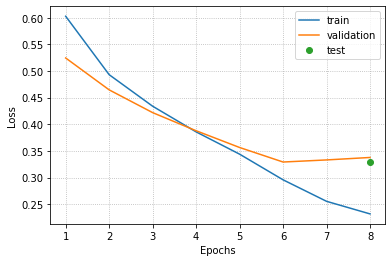

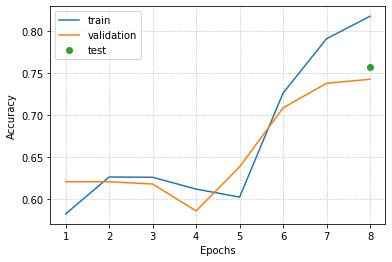

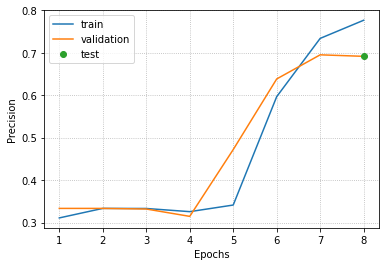

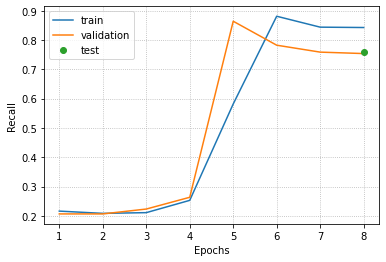

In [53]:
# plot results
_, ax1 = plt.subplots()
ax1 = plot_results(ax1, train_losses, val_losses, test_loss, 'Loss')
_, ax2 = plt.subplots()
ax2 = plot_results(ax2, train_metrics[:, 0], val_metrics[:, 0],
                   test_acc, 'Accuracy')
_, ax3 = plt.subplots()
ax3 = plot_results(ax3, train_metrics[:, 1], val_metrics[:, 1],
                   test_prec, 'Precision')
_, ax4 = plt.subplots()
ax4 = plot_results(ax4, train_metrics[:, 2], val_metrics[:, 2],
                   test_rec, 'Recall')
plt.show()